In [1]:
import numpy as np
import pandas as pd

In [3]:
a = 2
b = 1
c = 2.1
d = 0.85
t_max = 5
dt = 0.01
vartheta = np.pi/9

p = np.sin(vartheta) / (np.sqrt( c**2 * np.sin(vartheta)**2 + a**2 * np.cos(vartheta)**2 ))
A = np.sqrt((b**2) - ((a*d-b*c)**2) * (p**2)) / ((a*d-b*c)*p) 
B = (-b) / ((a*d-b*c) *p)
c_1 = np.arctanh((a*d - (a*d-b*c) * np.sqrt(1- c**2 * p**2)) / (c*np.sqrt(b**2 - (a*d-b*c)**2 * p**2)))
Y_0 = np.tanh(c_1)
c_2 = (-2/(p*b)) * ((np.arctanh(Y_0)/(A*B)) + (np.arctan(A*Y_0+B)/B) - (1/(1+(A*Y_0 + B)**2)))
            

def analytic_solution(vartheta, dt, t_max):
    x_analytic = []
    z_analytic = []
    p_x_analytic = []
    p_z_analytic = []
    time = []
    for time_step in range(int(t_max / dt) + 1):
        t = time_step * dt
        Y = np.tanh((b*A*t)/(2*B) + c_1)
        x = (2 / (p * b)) * ((np.arctanh(Y)/(A*B)) + (np.arctan(A*Y+B)/B) - (1/(1+(A*Y + B)**2))) + c_2
        z = (2*(A*Y + B)) / (d*p*(1+(A*Y + B)**2)) - (c/d)
        p_x = p
        p_z = (d * p * B * (1-(A*Y + B)**2))/(b*(A**2)*(1-Y**2))
        
        
        time.append(t)
        x_analytic.append(x)
        z_analytic.append(z)
        p_x_analytic.append(p_x)
        p_z_analytic.append(p_z)

    data_df = pd.DataFrame({
        'x': x_analytic,
        'z': z_analytic,
        'p_x': p_x_analytic,
        'p_z': p_z_analytic,
        't': time
    })

    return data_df


In [5]:
def generate_training_time(t_max, dt):
    training_time = []
    for i in range(int(t_max/dt + 1)):
        training_time.append(i*dt)
    return training_time

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

torch.manual_seed(0)

# model
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)
        self.linear_4 = nn.Linear(hidden_size, hidden_size)
        self.linear_5 = nn.Linear(hidden_size, hidden_size)
        self.linear_6 = nn.Linear(hidden_size, hidden_size)
        self.linear_output = nn.Linear(hidden_size, 4)

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))
        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))
        x = torch.tanh(self.linear_4(x))
        x = torch.tanh(self.linear_5(x))
        x = torch.tanh(self.linear_6(x))
        x = self.linear_output(x)
        return x

hidden_size= 48
num_epochs = 45000
lr=0.001

In [8]:
# Define the model, loss function, optimizer and scheduler
model = Net(hidden_size=hidden_size)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

training_time = generate_training_time(t_max, dt)
training_time_tensor = torch.tensor(training_time)

initial_time = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
final_time = torch.tensor([t_max], dtype=torch.float32).requires_grad_(True)

batch_size = len(training_time_tensor)
dataset = TensorDataset(training_time_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses_total = []
losses_physics = []
losses_IC = []
losses_energy = []

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad() 
    for batch in data_loader:
        batch_time = torch.tensor(batch[0])       
        batch_time = batch_time.requires_grad_(True).view(-1, 1)

        ##################################################################################
        # Calculate the physics loss

        output = model(batch_time)
        output_x = output[:, 0].view(-1, 1)
        output_z = output[:, 1].view(-1, 1)
        output_p_x = output[:, 2].view(-1, 1)
        output_p_z = output[:, 3].view(-1, 1)
        
        ##################################################################################
        # Calculate the derivatives

        xdot = torch.autograd.grad(output_x, batch_time, torch.ones_like(output_x), create_graph=True)[0]
        zdot = torch.autograd.grad(output_z, batch_time, torch.ones_like(output_z), create_graph=True)[0]
        p_x_dot = torch.autograd.grad(output_p_x, batch_time, torch.ones_like(output_p_x), create_graph=True)[0]
        p_z_dot = torch.autograd.grad(output_p_z, batch_time, torch.ones_like(output_p_z), create_graph=True)[0]

        ##################################################################################
        # Write down the Hamiltonian and calculate the energy loss
        
        h = ((c+d*output_z)**2 * output_p_x**2 + (a+b*output_z)**2 * output_p_z**2 - 1 ) / 2

        energy_loss = torch.mean(h**2)
        
        ##################################################################################
        # Calculate the physics loss
        
        h_x = (xdot - (c + d * output_z)**2 * output_p_x)
        h_z = (zdot - (a + b * output_z)**2 * output_p_z)
        h_p_x = (p_x_dot)
        h_p_z = (p_z_dot + (d*(c+d*output_z)*output_p_x**2 + b*(a+b*output_z)*output_p_z**2))

        physics_x_loss = torch.mean(h_x**2)
        physics_z_loss = torch.mean(h_z**2)
        physics_p_x_loss = torch.mean(h_p_x**2)
        physics_p_z_loss = torch.mean(h_p_z**2)


        ##################################################################################
        # Calculate the initial position and momentum loss

        x_0_tensor = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
        z_0_tensor = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)

        initial_outputs = model(initial_time)

        initial_position_loss_x = (initial_outputs[0] - x_0_tensor)**2
        initial_position_loss_z = (initial_outputs[1] - z_0_tensor)**2
        
        initial_momentum_loss_x = (initial_outputs[2] - np.sin(vartheta) / (np.sqrt( c**2 * np.sin(vartheta)**2 + a**2 * np.cos(vartheta)**2 ))) ** 2
        initial_momentum_loss_z = (initial_outputs[3] - np.cos(vartheta) / (np.sqrt( c**2 * np.sin(vartheta)**2 + a**2 * np.cos(vartheta)**2 ))) ** 2
      
        ##################################################################################
        # Calculate the total loss
        physics_loss = physics_x_loss * 1e3 +  physics_z_loss * 1e3 + physics_p_x_loss * 1e5 + physics_p_z_loss * 1e5
        IC_loss = initial_position_loss_x * 1e3 + initial_position_loss_z * 1e3 + initial_momentum_loss_x * 1e5 + initial_momentum_loss_z * 1e5 
        
        total_loss =  physics_x_loss * 1e3 +  physics_z_loss * 1e3 + physics_p_x_loss * 1e5 + physics_p_z_loss * 1e5 + initial_position_loss_x * 1e3 + initial_position_loss_z * 1e3 + initial_momentum_loss_x * 1e5 + initial_momentum_loss_z * 1e5 + energy_loss * 1e5
        
        ##################################################################################

        total_loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        ##################################################################################

        # Save the losses
        
        losses_physics.append(physics_loss.item())
        losses_IC.append(IC_loss.item())
        losses_energy.append(energy_loss.item())
        losses_total.append(total_loss.item())

        
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss.item():.2e}, "
              f"Total Physics Loss: {physics_loss.item():.2e}, "
              f"Initial Position Loss x: {initial_position_loss_x.item():.2e}, "
              f"Initial Position Loss z: {initial_position_loss_z.item():.2e}, "
              f"Initial Momentum Loss x: {initial_momentum_loss_x.item():.2e}, "
              f"Initial Momentum Loss z: {initial_momentum_loss_z.item():.2e}, "
              f"Energy Loss: {energy_loss.item():.2e}, "
              f"LR: {optimizer.param_groups[0]['lr']}")
    
    ##############################################################################

    # if the learning rate is too low, do not decrease the learning rate
    if optimizer.param_groups[0]['lr'] > 1e-6: 
        scheduler.step()  # Update the learning rate 

  0%|          | 0/45000 [00:00<?, ?it/s]C:\Users\Selin\AppData\Local\Temp\ipykernel_12212\3515364752.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_time = torch.tensor(batch[0])
  2%|▏         | 1010/45000 [00:17<13:16, 55.23it/s]

Epoch 1000/45000, Total Loss: 1.69e+02, Total Physics Loss: 1.22e+02, Initial Position Loss x: 1.16e-02, Initial Position Loss z: 7.35e-04, Initial Momentum Loss x: 2.04e-07, Initial Momentum Loss z: 7.59e-06, Energy Loss: 3.41e-04, LR: 0.001


  4%|▍         | 2009/45000 [00:36<14:29, 49.42it/s]

Epoch 2000/45000, Total Loss: 4.12e+01, Total Physics Loss: 3.48e+01, Initial Position Loss x: 3.03e-04, Initial Position Loss z: 2.30e-06, Initial Momentum Loss x: 5.24e-06, Initial Momentum Loss z: 4.83e-06, Energy Loss: 5.14e-05, LR: 0.0009000000000000001


  7%|▋         | 3008/45000 [00:56<14:34, 48.04it/s]

Epoch 3000/45000, Total Loss: 2.28e+01, Total Physics Loss: 1.39e+01, Initial Position Loss x: 1.70e-03, Initial Position Loss z: 1.21e-05, Initial Momentum Loss x: 8.55e-06, Initial Momentum Loss z: 3.94e-07, Energy Loss: 6.30e-05, LR: 0.0008100000000000001


  9%|▉         | 4006/45000 [01:16<13:36, 50.18it/s]

Epoch 4000/45000, Total Loss: 7.81e+00, Total Physics Loss: 6.96e+00, Initial Position Loss x: 3.43e-06, Initial Position Loss z: 5.37e-06, Initial Momentum Loss x: 3.20e-06, Initial Momentum Loss z: 7.38e-07, Energy Loss: 4.47e-06, LR: 0.000729


 11%|█         | 5006/45000 [01:36<12:45, 52.25it/s]

Epoch 5000/45000, Total Loss: 4.63e+00, Total Physics Loss: 4.18e+00, Initial Position Loss x: 3.54e-07, Initial Position Loss z: 1.06e-07, Initial Momentum Loss x: 2.46e-06, Initial Momentum Loss z: 7.08e-08, Energy Loss: 2.00e-06, LR: 0.0006561000000000001


 13%|█▎        | 6009/45000 [01:57<12:45, 50.92it/s]

Epoch 6000/45000, Total Loss: 6.87e+00, Total Physics Loss: 5.27e+00, Initial Position Loss x: 1.93e-04, Initial Position Loss z: 2.79e-06, Initial Momentum Loss x: 1.46e-07, Initial Momentum Loss z: 3.52e-08, Energy Loss: 1.38e-05, LR: 0.00059049


 16%|█▌        | 7009/45000 [02:17<12:49, 49.39it/s]

Epoch 7000/45000, Total Loss: 2.32e+00, Total Physics Loss: 2.08e+00, Initial Position Loss x: 4.47e-06, Initial Position Loss z: 2.05e-06, Initial Momentum Loss x: 7.93e-07, Initial Momentum Loss z: 8.05e-11, Energy Loss: 1.54e-06, LR: 0.000531441


 18%|█▊        | 8007/45000 [02:38<12:42, 48.50it/s]

Epoch 8000/45000, Total Loss: 1.06e+01, Total Physics Loss: 5.80e+00, Initial Position Loss x: 6.82e-04, Initial Position Loss z: 1.92e-04, Initial Momentum Loss x: 1.47e-06, Initial Momentum Loss z: 6.16e-06, Energy Loss: 3.19e-05, LR: 0.0004782969


 20%|██        | 9004/45000 [03:01<11:52, 50.54it/s]

Epoch 9000/45000, Total Loss: 1.22e+00, Total Physics Loss: 1.13e+00, Initial Position Loss x: 4.37e-06, Initial Position Loss z: 2.46e-08, Initial Momentum Loss x: 2.81e-07, Initial Momentum Loss z: 2.12e-08, Energy Loss: 5.62e-07, LR: 0.00043046721


 22%|██▏       | 10008/45000 [03:22<11:40, 49.93it/s]

Epoch 10000/45000, Total Loss: 9.31e-01, Total Physics Loss: 8.59e-01, Initial Position Loss x: 1.44e-07, Initial Position Loss z: 4.61e-07, Initial Momentum Loss x: 1.96e-07, Initial Momentum Loss z: 1.11e-08, Energy Loss: 5.11e-07, LR: 0.000387420489


 24%|██▍       | 11007/45000 [03:43<11:31, 49.15it/s]

Epoch 11000/45000, Total Loss: 6.95e-01, Total Physics Loss: 6.43e-01, Initial Position Loss x: 5.70e-06, Initial Position Loss z: 3.73e-07, Initial Momentum Loss x: 8.14e-08, Initial Momentum Loss z: 2.73e-09, Energy Loss: 3.71e-07, LR: 0.0003486784401


 27%|██▋       | 12009/45000 [04:04<11:25, 48.13it/s]

Epoch 12000/45000, Total Loss: 5.24e-01, Total Physics Loss: 4.72e-01, Initial Position Loss x: 2.72e-06, Initial Position Loss z: 3.62e-08, Initial Momentum Loss x: 1.36e-07, Initial Momentum Loss z: 4.90e-09, Energy Loss: 3.55e-07, LR: 0.00031381059609000004


 29%|██▉       | 13007/45000 [04:25<11:01, 48.35it/s]

Epoch 13000/45000, Total Loss: 9.79e-01, Total Physics Loss: 5.69e-01, Initial Position Loss x: 1.24e-04, Initial Position Loss z: 1.45e-05, Initial Momentum Loss x: 3.12e-07, Initial Momentum Loss z: 7.42e-07, Energy Loss: 1.66e-06, LR: 0.00028242953648100003


 31%|███       | 14008/45000 [04:48<10:32, 48.97it/s]

Epoch 14000/45000, Total Loss: 1.06e+01, Total Physics Loss: 4.26e+00, Initial Position Loss x: 1.64e-03, Initial Position Loss z: 3.76e-06, Initial Momentum Loss x: 3.50e-06, Initial Momentum Loss z: 3.99e-07, Energy Loss: 4.36e-05, LR: 0.00025418658283290005


 33%|███▎      | 15005/45000 [05:09<10:37, 47.04it/s]

Epoch 15000/45000, Total Loss: 7.05e-01, Total Physics Loss: 3.69e-01, Initial Position Loss x: 1.06e-04, Initial Position Loss z: 1.53e-05, Initial Momentum Loss x: 2.46e-07, Initial Momentum Loss z: 5.55e-07, Energy Loss: 1.34e-06, LR: 0.00022876792454961005


 36%|███▌      | 16006/45000 [05:30<09:52, 48.92it/s]

Epoch 16000/45000, Total Loss: 2.50e+00, Total Physics Loss: 1.11e+00, Initial Position Loss x: 2.15e-04, Initial Position Loss z: 2.61e-06, Initial Momentum Loss x: 2.43e-07, Initial Momentum Loss z: 5.89e-07, Energy Loss: 1.09e-05, LR: 0.00020589113209464906


 38%|███▊      | 17008/45000 [05:52<10:08, 46.03it/s]

Epoch 17000/45000, Total Loss: 2.48e-01, Total Physics Loss: 1.98e-01, Initial Position Loss x: 5.98e-06, Initial Position Loss z: 2.95e-06, Initial Momentum Loss x: 2.03e-09, Initial Momentum Loss z: 3.18e-08, Energy Loss: 3.69e-07, LR: 0.00018530201888518417


 40%|████      | 18007/45000 [06:13<09:01, 49.83it/s]

Epoch 18000/45000, Total Loss: 1.44e-01, Total Physics Loss: 1.29e-01, Initial Position Loss x: 5.77e-07, Initial Position Loss z: 1.06e-07, Initial Momentum Loss x: 1.52e-08, Initial Momentum Loss z: 6.69e-09, Energy Loss: 1.23e-07, LR: 0.00016677181699666576


 42%|████▏     | 19010/45000 [06:34<08:57, 48.34it/s]

Epoch 19000/45000, Total Loss: 1.20e-01, Total Physics Loss: 1.12e-01, Initial Position Loss x: 1.11e-07, Initial Position Loss z: 1.61e-07, Initial Momentum Loss x: 5.05e-09, Initial Momentum Loss z: 1.18e-10, Energy Loss: 7.34e-08, LR: 0.0001500946352969992


 44%|████▍     | 20008/45000 [06:56<08:41, 47.92it/s]

Epoch 20000/45000, Total Loss: 1.06e-01, Total Physics Loss: 9.85e-02, Initial Position Loss x: 2.60e-07, Initial Position Loss z: 6.29e-09, Initial Momentum Loss x: 2.91e-09, Initial Momentum Loss z: 9.57e-10, Energy Loss: 6.86e-08, LR: 0.0001350851717672993


 47%|████▋     | 21007/45000 [07:18<08:31, 46.90it/s]

Epoch 21000/45000, Total Loss: 9.22e-02, Total Physics Loss: 8.56e-02, Initial Position Loss x: 5.62e-08, Initial Position Loss z: 4.34e-09, Initial Momentum Loss x: 5.18e-09, Initial Momentum Loss z: 4.48e-10, Energy Loss: 5.98e-08, LR: 0.00012157665459056936


 49%|████▉     | 22009/45000 [07:40<08:09, 46.97it/s]

Epoch 22000/45000, Total Loss: 9.05e-02, Total Physics Loss: 7.98e-02, Initial Position Loss x: 1.10e-06, Initial Position Loss z: 8.53e-08, Initial Momentum Loss x: 8.31e-09, Initial Momentum Loss z: 4.24e-09, Energy Loss: 8.22e-08, LR: 0.00010941898913151243


 51%|█████     | 23005/45000 [08:03<09:47, 37.46it/s]

Epoch 23000/45000, Total Loss: 7.59e-02, Total Physics Loss: 7.10e-02, Initial Position Loss x: 5.02e-10, Initial Position Loss z: 2.17e-08, Initial Momentum Loss x: 2.58e-09, Initial Momentum Loss z: 6.57e-11, Energy Loss: 4.57e-08, LR: 9.847709021836118e-05


 53%|█████▎    | 24005/45000 [08:28<07:58, 43.87it/s]

Epoch 24000/45000, Total Loss: 1.13e+00, Total Physics Loss: 6.60e-01, Initial Position Loss x: 2.81e-07, Initial Position Loss z: 1.51e-05, Initial Momentum Loss x: 1.00e-10, Initial Momentum Loss z: 2.66e-07, Energy Loss: 4.25e-06, LR: 8.862938119652506e-05


 56%|█████▌    | 25007/45000 [08:53<07:54, 42.16it/s]

Epoch 25000/45000, Total Loss: 6.55e-02, Total Physics Loss: 6.14e-02, Initial Position Loss x: 1.88e-08, Initial Position Loss z: 6.03e-08, Initial Momentum Loss x: 1.29e-09, Initial Momentum Loss z: 7.47e-11, Energy Loss: 3.93e-08, LR: 7.976644307687256e-05


 58%|█████▊    | 26006/45000 [09:15<06:56, 45.58it/s]

Epoch 26000/45000, Total Loss: 6.13e-02, Total Physics Loss: 5.76e-02, Initial Position Loss x: 6.63e-10, Initial Position Loss z: 2.28e-08, Initial Momentum Loss x: 1.29e-09, Initial Momentum Loss z: 3.04e-11, Energy Loss: 3.52e-08, LR: 7.17897987691853e-05


 60%|██████    | 27006/45000 [09:38<07:24, 40.44it/s]

Epoch 27000/45000, Total Loss: 3.56e-01, Total Physics Loss: 2.37e-01, Initial Position Loss x: 1.95e-07, Initial Position Loss z: 4.19e-06, Initial Momentum Loss x: 6.75e-10, Initial Momentum Loss z: 3.34e-08, Energy Loss: 1.12e-06, LR: 6.461081889226677e-05


 62%|██████▏   | 28008/45000 [10:01<06:12, 45.67it/s]

Epoch 28000/45000, Total Loss: 1.98e-01, Total Physics Loss: 1.22e-01, Initial Position Loss x: 1.24e-05, Initial Position Loss z: 4.42e-06, Initial Momentum Loss x: 5.96e-09, Initial Momentum Loss z: 7.34e-08, Energy Loss: 5.03e-07, LR: 5.81497370030401e-05


 64%|██████▍   | 29003/45000 [10:26<08:08, 32.76it/s]

Epoch 29000/45000, Total Loss: 7.07e-02, Total Physics Loss: 5.89e-02, Initial Position Loss x: 1.22e-06, Initial Position Loss z: 6.71e-07, Initial Momentum Loss x: 3.14e-11, Initial Momentum Loss z: 9.01e-09, Energy Loss: 9.09e-08, LR: 5.233476330273609e-05


 67%|██████▋   | 30008/45000 [10:49<05:48, 43.07it/s]

Epoch 30000/45000, Total Loss: 1.83e-01, Total Physics Loss: 1.14e-01, Initial Position Loss x: 6.84e-06, Initial Position Loss z: 3.87e-06, Initial Momentum Loss x: 2.26e-09, Initial Momentum Loss z: 7.15e-08, Energy Loss: 5.07e-07, LR: 4.7101286972462485e-05


 69%|██████▉   | 31002/45000 [11:12<09:17, 25.12it/s]

Epoch 31000/45000, Total Loss: 8.02e-02, Total Physics Loss: 6.63e-02, Initial Position Loss x: 3.24e-08, Initial Position Loss z: 2.01e-07, Initial Momentum Loss x: 8.06e-10, Initial Momentum Loss z: 4.22e-11, Energy Loss: 1.36e-07, LR: 4.239115827521624e-05


 71%|███████   | 32005/45000 [11:37<04:52, 44.40it/s]

Epoch 32000/45000, Total Loss: 5.05e-02, Total Physics Loss: 4.43e-02, Initial Position Loss x: 1.87e-07, Initial Position Loss z: 1.14e-07, Initial Momentum Loss x: 1.31e-10, Initial Momentum Loss z: 3.44e-09, Energy Loss: 5.60e-08, LR: 3.8152042447694614e-05


 73%|███████▎  | 33008/45000 [12:00<04:45, 42.04it/s]

Epoch 33000/45000, Total Loss: 4.47e-02, Total Physics Loss: 4.21e-02, Initial Position Loss x: 1.90e-09, Initial Position Loss z: 2.88e-08, Initial Momentum Loss x: 3.29e-10, Initial Momentum Loss z: 2.94e-11, Energy Loss: 2.46e-08, LR: 3.433683820292515e-05


 76%|███████▌  | 34009/45000 [12:23<03:53, 47.02it/s]

Epoch 34000/45000, Total Loss: 3.05e-01, Total Physics Loss: 1.86e-01, Initial Position Loss x: 5.40e-06, Initial Position Loss z: 3.77e-06, Initial Momentum Loss x: 6.41e-09, Initial Momentum Loss z: 6.39e-08, Energy Loss: 1.03e-06, LR: 3.090315438263264e-05


 78%|███████▊  | 35006/45000 [12:45<03:48, 43.74it/s]

Epoch 35000/45000, Total Loss: 5.60e-02, Total Physics Loss: 4.77e-02, Initial Position Loss x: 6.85e-08, Initial Position Loss z: 3.75e-08, Initial Momentum Loss x: 1.29e-11, Initial Momentum Loss z: 7.90e-10, Energy Loss: 8.13e-08, LR: 2.7812838944369376e-05


 80%|████████  | 36005/45000 [13:08<03:31, 42.55it/s]

Epoch 36000/45000, Total Loss: 4.10e-02, Total Physics Loss: 3.88e-02, Initial Position Loss x: 6.00e-08, Initial Position Loss z: 4.63e-09, Initial Momentum Loss x: 5.26e-10, Initial Momentum Loss z: 1.98e-10, Energy Loss: 2.08e-08, LR: 2.503155504993244e-05


 82%|████████▏ | 37003/45000 [13:31<03:36, 36.95it/s]

Epoch 37000/45000, Total Loss: 3.97e-02, Total Physics Loss: 3.76e-02, Initial Position Loss x: 2.36e-09, Initial Position Loss z: 1.25e-08, Initial Momentum Loss x: 2.43e-10, Initial Momentum Loss z: 2.59e-12, Energy Loss: 2.08e-08, LR: 2.2528399544939195e-05


 84%|████████▍ | 38005/45000 [13:54<02:46, 42.06it/s]

Epoch 38000/45000, Total Loss: 3.94e-02, Total Physics Loss: 3.70e-02, Initial Position Loss x: 6.97e-08, Initial Position Loss z: 2.66e-10, Initial Momentum Loss x: 4.28e-10, Initial Momentum Loss z: 4.33e-10, Energy Loss: 2.27e-08, LR: 2.0275559590445276e-05


 87%|████████▋ | 39007/45000 [14:17<02:13, 44.77it/s]

Epoch 39000/45000, Total Loss: 3.79e-02, Total Physics Loss: 3.60e-02, Initial Position Loss x: 1.94e-09, Initial Position Loss z: 9.17e-09, Initial Momentum Loss x: 1.73e-10, Initial Momentum Loss z: 1.69e-11, Energy Loss: 1.92e-08, LR: 1.8248003631400748e-05


 89%|████████▉ | 40006/45000 [14:39<01:48, 46.02it/s]

Epoch 40000/45000, Total Loss: 3.71e-02, Total Physics Loss: 3.52e-02, Initial Position Loss x: 1.12e-09, Initial Position Loss z: 1.08e-08, Initial Momentum Loss x: 1.44e-10, Initial Momentum Loss z: 7.19e-12, Energy Loss: 1.85e-08, LR: 1.6423203268260675e-05


 91%|█████████ | 41005/45000 [15:02<01:44, 38.14it/s]

Epoch 41000/45000, Total Loss: 3.64e-02, Total Physics Loss: 3.46e-02, Initial Position Loss x: 3.68e-10, Initial Position Loss z: 1.12e-08, Initial Momentum Loss x: 1.18e-10, Initial Momentum Loss z: 3.41e-12, Energy Loss: 1.80e-08, LR: 1.4780882941434607e-05


 93%|█████████▎| 42007/45000 [15:25<01:04, 46.68it/s]

Epoch 42000/45000, Total Loss: 3.57e-02, Total Physics Loss: 3.40e-02, Initial Position Loss x: 9.83e-10, Initial Position Loss z: 1.07e-08, Initial Momentum Loss x: 1.11e-10, Initial Momentum Loss z: 4.35e-12, Energy Loss: 1.75e-08, LR: 1.3302794647291146e-05


 96%|█████████▌| 43005/45000 [15:47<00:47, 42.19it/s]

Epoch 43000/45000, Total Loss: 3.51e-02, Total Physics Loss: 3.34e-02, Initial Position Loss x: 1.27e-09, Initial Position Loss z: 9.82e-09, Initial Momentum Loss x: 1.00e-10, Initial Momentum Loss z: 5.97e-12, Energy Loss: 1.70e-08, LR: 1.1972515182562031e-05


 98%|█████████▊| 44007/45000 [16:10<00:22, 45.08it/s]

Epoch 44000/45000, Total Loss: 3.66e-02, Total Physics Loss: 3.39e-02, Initial Position Loss x: 2.72e-07, Initial Position Loss z: 1.12e-07, Initial Momentum Loss x: 6.50e-11, Initial Momentum Loss z: 1.11e-09, Energy Loss: 2.19e-08, LR: 1.0775263664305828e-05


100%|██████████| 45000/45000 [16:34<00:00, 45.26it/s]

Epoch 45000/45000, Total Loss: 3.40e-02, Total Physics Loss: 3.23e-02, Initial Position Loss x: 2.25e-10, Initial Position Loss z: 1.60e-08, Initial Momentum Loss x: 5.48e-11, Initial Momentum Loss z: 6.42e-12, Energy Loss: 1.62e-08, LR: 9.697737297875246e-06


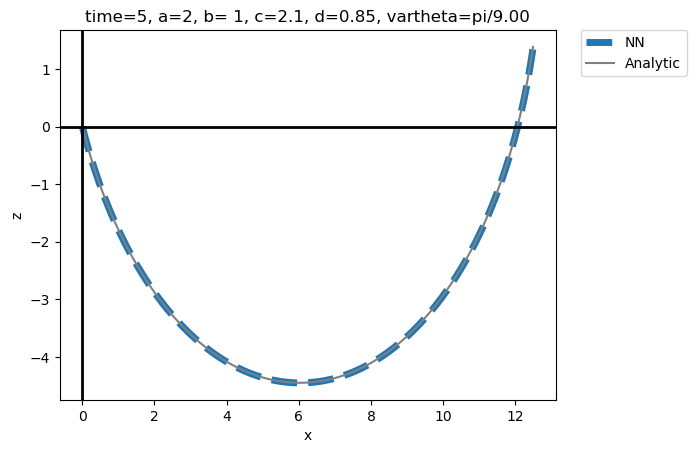

In [11]:
result_outputs = model(training_time_tensor.view(-1, 1))

result_outputs_df = pd.DataFrame(result_outputs.detach().numpy())
result_outputs_df.columns = ['x', 'z', 'p_x', 'p_z']
result_outputs_df["t"] = training_time

   
result_outputs_df["z"] = result_outputs_df["z"] * -1
result_outputs_df["slope"] = result_outputs_df["x"] / result_outputs_df["z"]


result_outputs_df.to_excel("result_outputs_df.xlsx")

true_solution_df = analytic_solution(vartheta, dt, t_max)

 
plt.plot(result_outputs_df["x"],  result_outputs_df["z"], label = "NN",  linewidth=5, c = "tab:blue", linestyle='dashed')
plt.plot(true_solution_df["x"], true_solution_df["z"] * - 1, label = "Analytic", c = "grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(f"time={t_max}, a={a}, b= {b}, c={c}, d={d}, vartheta=pi/{np.pi/vartheta:.2f}")
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.xlabel("x")
plt.ylabel("z")
#plt.xlim(-0.1, 3)
#plt.ylim(-5, 0.5)
plt.show()

Final loss: 0.03397398442029953


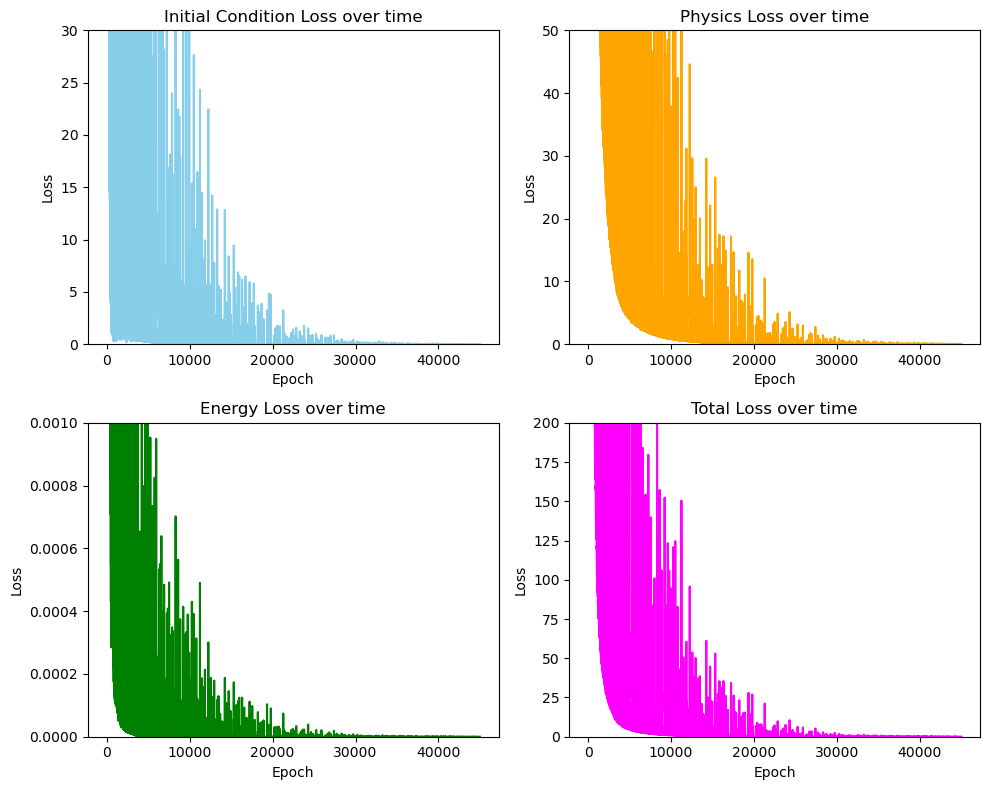

In [13]:
print('Final loss:', total_loss.item())

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(losses_IC, label='Initial Condition Loss ', color='skyblue')
axs[0, 0].set_title('Initial Condition Loss over time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 30)

axs[0, 1].plot(losses_physics, label='Hamiltonian Loss', color='orange')
axs[0, 1].set_title('Physics Loss over time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0, 50)

axs[1, 0].plot(losses_energy, label='Energy Loss', color='green')
axs[1, 0].set_title('Energy Loss over time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_ylim(0, 1e-3)

axs[1, 1].plot(losses_total, label='Total Loss', color='magenta')
axs[1, 1].set_title('Total Loss over time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_ylim(0, 200)

plt.tight_layout()
plt.show()


In [42]:
print(len(training_time_tensor))

501
